# CHF Prediction with XGBoost using Short-Term HRV Signals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, fbeta_score, classification_report, \
                            roc_auc_score, \
                            ConfusionMatrixDisplay, RocCurveDisplay

import datetime
import os
import pprint

In [2]:
def classification_report_heatmap(cr, label_names, model_name):
    corr_matrix = []

    for label in label_names:
        if cr[label]:
            row = [cr[label]['precision'], cr[label]['recall'], cr[label]['f1-score']]
            corr_matrix.append(row)

    sns.heatmap(
        pd.DataFrame(np.array(corr_matrix), index=label_names, columns=['precision', 'recall', 'f1-score']),
        annot=True,
        cmap='Blues',
        vmin=0,
        vmax=1
    )

    plt.title("Classification Report Heatmap\nModel: {0}".format(model_name))
    plt.tight_layout()
    plt.show()

## Load Dataset

In [3]:
import pathlib

par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
pathlib.Path(par_dir).parent.absolute()

WindowsPath('c:/Users/BIOINFO 9/Documents/Rino/HRV')

In [4]:
PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
# PROJECT_DIR = pathlib.Path(par_dir).parent.absolute()
# PROJECT_DIR = "/content/drive/MyDrive/Projects/HRV"
DATA_DIR = os.path.join(PROJECT_DIR, "dataset/short-term")

In [5]:
MINS_DIR = "5-min-2-hours-0.5-overlap-normal-beat-with-ectopic-info"
df_nsrdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsrdb.xlsx"))
df_chfdb = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chfdb.xlsx"))
df_nsr2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_nsr2db.xlsx"))
df_chf2db = pd.read_excel(os.path.join(DATA_DIR, MINS_DIR, "df_chf2db.xlsx"))
df = pd.concat(
    [
        df_nsrdb,
        df_chfdb,
    ],
    axis=0
).reset_index(drop=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1584 non-null   object 
 1   start_secs              1584 non-null   int64  
 2   end_secs                1584 non-null   int64  
 3   db_source               1584 non-null   object 
 4   age                     1584 non-null   object 
 5   gender                  1584 non-null   object 
 6   fs                      1584 non-null   int64  
 7   signal_length           1584 non-null   int64  
 8   recording_time_hours    1584 non-null   float64
 9   recording_time_seconds  1584 non-null   int64  
 10  normal_beats            1584 non-null   int64  
 11  abnormal_beats          1584 non-null   int64  
 12  normal_beats_ratio      1584 non-null   float64
 13  rri_length              1584 non-null   int64  
 14  nni_length              1584 non-null   

## Data Cleaning & Filtering

In [7]:
df_loaded = df.copy()

In [8]:
map_gender = {"m": 1, "f": 0}

# df = df.dropna()
df = df_loaded.copy()
df = df[(df.age != "?") & (df.gender != "?")]
df = df.replace(["?"], np.nan)
df['age'] = np.array(df['age'], dtype=np.float16)
df['gender'] = df['gender'].map(lambda x: map_gender[x.lower()])
df["record_ids"] = df["id"].map(lambda x: "-".join(x.split("-")[:2]))
df = df[["id", "record_ids"] + df.drop(columns=["id", "record_ids"]).columns.to_list()]
df = df.drop(columns=['tinn'])
df = df.replace([np.inf, -np.inf], np.nan)
# df = df[df['age'] >= 10] # useless since no data with age > 10 in CHFDB, CHF2DB, NSRDB, NSR2DB
df = df[df["normal_beats_ratio"] >= 0.9]

if 'db_source' in df.columns:
    db_source = df['db_source']
    df = df.drop(columns=['db_source'])
drop_columns = ["signal_length", "recording_time_hours", "recording_time_seconds"]
df = df.drop(columns=drop_columns)

df = df.dropna()
df["ratio_sd1_sd2"] = 1 / df["ratio_sd2_sd1"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 0 to 1583
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1445 non-null   object 
 1   record_ids          1445 non-null   object 
 2   start_secs          1445 non-null   int64  
 3   end_secs            1445 non-null   int64  
 4   age                 1445 non-null   float16
 5   gender              1445 non-null   int64  
 6   fs                  1445 non-null   int64  
 7   normal_beats        1445 non-null   int64  
 8   abnormal_beats      1445 non-null   int64  
 9   normal_beats_ratio  1445 non-null   float64
 10  rri_length          1445 non-null   int64  
 11  nni_length          1445 non-null   int64  
 12  mean_nni            1445 non-null   float64
 13  sdnn                1445 non-null   float64
 14  sdsd                1445 non-null   float64
 15  nni_50              1445 non-null   int64  
 16  pnni_5

In [9]:
db_source.value_counts()

nsrdb    780
chfdb    665
Name: db_source, dtype: int64

## Train-Test Split

In [10]:
train_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "train_record_ids_7-3_post-filter.csv"))
test_record_ids = pd.read_csv(os.path.join(PROJECT_DIR, "dataset", "test_record_ids_7-3_post-filter.csv"))

df_train = df[
    df["record_ids"].isin(train_record_ids["id"].values)
]

df_test = df[
    df["record_ids"].isin(test_record_ids["id"].values)
]

print(df_train.shape)
print(df_test.shape)

df_train.sample(3)

(844, 46)
(601, 46)


,id,record_ids,start_secs,end_secs,age,gender,fs,normal_beats,abnormal_beats,normal_beats_ratio,...,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk,ratio_sd1_sd2
414,nsrdb-16795-4500-4800,nsrdb-16795,4500,4800,20.0,0,128,380,0,1.000000,...,25.212145,90.675418,3.596498,3.596498,4.563219,1304.455692,1.587122,Sinus,0,0.278048
1308,chfdb-chf10-1800-2100,chfdb-chf10,1800,2100,22.0,1,250,599,0,1.000000,...,17.882500,21.340654,1.193382,1.193382,3.785756,101.870215,1.314595,NYHA class: III-IV,1,0.837955
862,nsrdb-19830-6900-7200,nsrdb-19830,6900,7200,50.0,0,128,541,21,0.962633,...,7.933693,30.699441,3.869502,3.869502,3.590726,475.166216,1.354949,Sinus,0,0.258431


In [11]:
df_inspect = df_test.copy()

In [12]:
data_info = ['age', 'gender', 'db_source']
time_domain_indices = ['mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr']
freq_domain_indices = ['lf', 'hf', 'lf_hf_ratio', 'lfnu', 'hfnu', 'total_power', 'vlf']
geometrical_indices = ['triangular_index']
poincare_plot_indices = ['sd1', 'sd2', 'ratio_sd1_sd2']
csi_csv_indices = ['csi', 'cvi', 'Modified_csi']
sampen = ['sampen']
disease_info = ['cardiac_info', 'risk']

## Feature Selection

In [13]:
columns_needed = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices + \
                 ['risk']

df_train = df_train[columns_needed]
df_test = df_test[columns_needed]

X_train = df_train.drop(columns=['risk'])
y_train = df_train['risk']
X_test = df_test.drop(columns=['risk'])
y_test = df_test['risk']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(844, 31) (844,)
(601, 31) (601,)


In [14]:
print(y_train.value_counts())
print(y_test.value_counts())

1    428
0    416
Name: risk, dtype: int64
0    364
1    237
Name: risk, dtype: int64


In [15]:
pd.set_option('display.max_columns', None)
df_train.sample(3)

,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi,risk
1320,22.0,1,505.241147,4.806829,5.739852,0,0.000000,0,0.000000,5.739856,504.0000,32.00000,0.011361,0.009514,118.765909,121.951220,114.503817,1.129445,2.772210,6.073263,0.456461,31.340441,68.659559,11.842558,2.997084,4.062121,5.450723,0.745244,1.341842,2.549327,29.256030,1
450,45.0,0,752.470703,72.814361,64.637165,36,9.022556,175,43.859649,64.638352,757.8125,542.96875,0.085901,0.096767,80.984550,165.161290,66.206897,13.414060,549.251886,834.339409,0.658307,39.697553,60.302447,2301.893692,918.302397,45.762761,92.247667,0.496086,2.015780,4.829588,743.804086,0
875,71.0,1,950.780952,67.560303,27.597317,7,2.229299,74,23.566879,27.599963,980.0000,316.00000,0.029029,0.071058,63.441496,81.521739,57.034221,4.740665,145.675919,91.467102,1.592659,61.429562,38.570438,671.949202,434.806182,19.545398,93.524149,0.208988,4.784970,4.466088,1790.041100,1


In [16]:
pd.reset_option('display.max_columns')

In [17]:
LABEL_NAMES = ["Healthy", "CHF"]

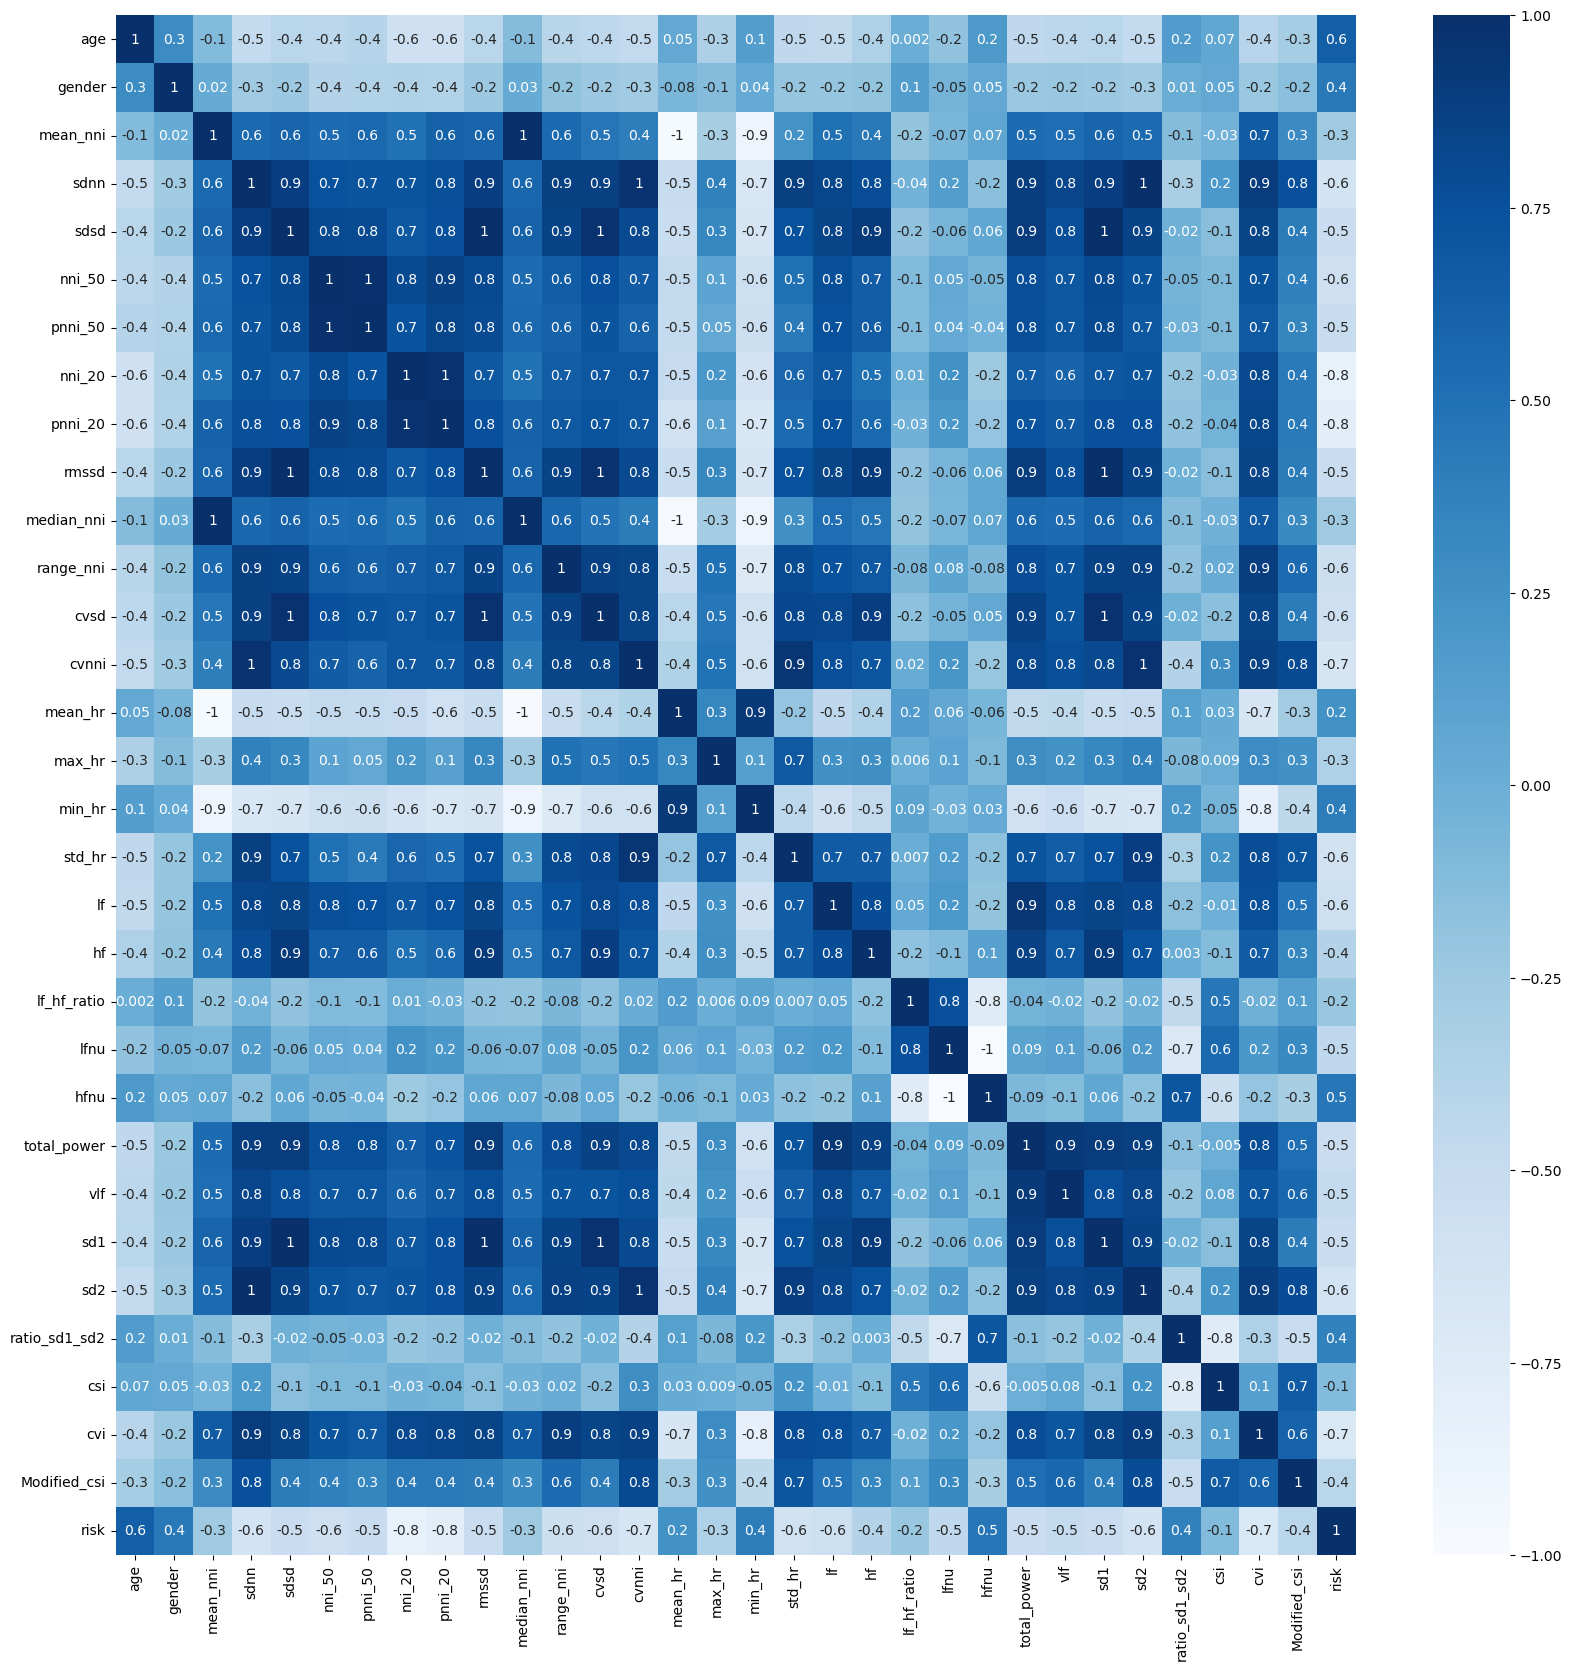

In [18]:
plt.rcParams['figure.figsize'] = (20, 20)
heatmap = sns.heatmap(df_train.corr(), annot=True, cmap="Blues", fmt='.1g')
plt.rcdefaults()
plt.show()

## XGBoost

In [19]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut

from sklearn.metrics import make_scorer

In [20]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

In [21]:
# A parameter grid for XGBoost
params = {
    'learning_rate': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 5, 10],
    'gamma': [1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [22]:
gs = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [23]:
start = datetime.datetime.now()
gs.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 31)
Fitting time: 0 hours, 1 minutes, 45 seconds, 377081 microseconds


## Evaluation

In [24]:
gs.score(X_test, y_test)

0.9201331114808652

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




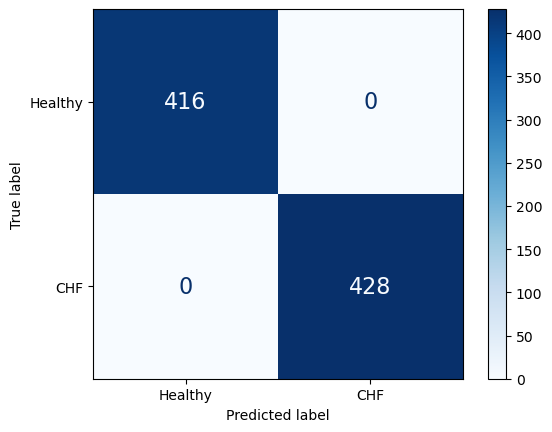


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 48 189
Accuracy             : 0.9201331114808652
Precision            : 0.9294379916966867
Sensitivity          : 0.7974683544303798
Specificity          : 1.0
F1-Score             : 0.9181036784199027
AUC Score            : 0.8987341772151899
              precision    recall  f1-score   support

     Healthy       0.88      1.00      0.94       364
         CHF       1.00      0.80      0.89       237

    accuracy                           0.92       601
   macro avg       0.94      0.90      0.91       601
weighted avg       0.93      0.92      0.92       601




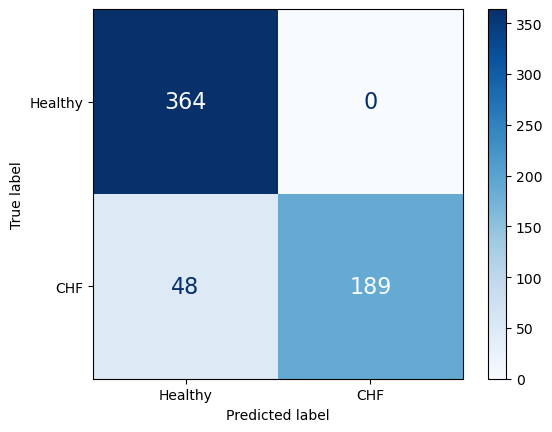

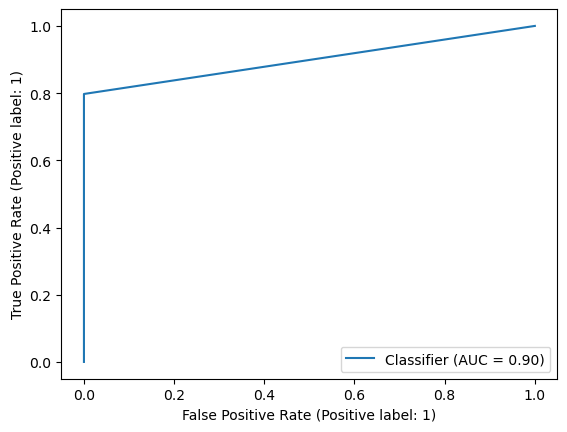

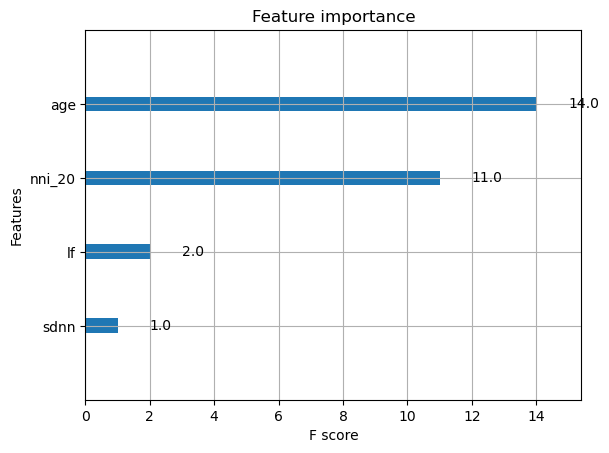

In [25]:
y_pred_train = gs.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs.best_estimator_)
plt.show()

In [26]:
print("Best Params")
pprint.pprint(gs.best_params_)
print()

Best Params
{'colsample_bytree': 1.0,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 1.0}



### Sensitivity

In [27]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall",
)

In [28]:
start = datetime.datetime.now()
gs_sensitivity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 31)
Fitting time: 0 hours, 1 minutes, 47 seconds, 657506 microseconds


In [29]:
gs_sensitivity.score(X_test, y_test)

0.7974683544303798

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




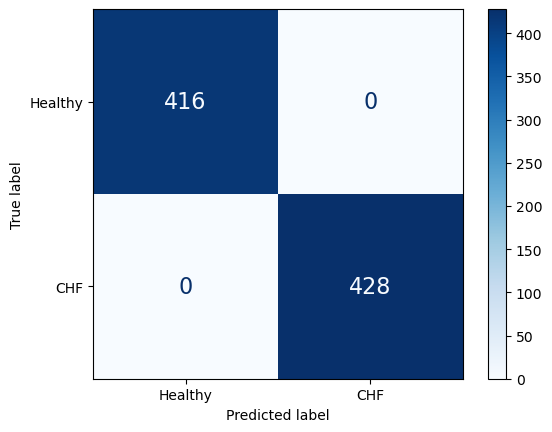


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 48 189
Accuracy             : 0.9201331114808652
Precision            : 0.9294379916966867
Sensitivity          : 0.7974683544303798
Specificity          : 1.0
F1-Score             : 0.9181036784199027
AUC Score            : 0.8987341772151899
              precision    recall  f1-score   support

     Healthy       0.88      1.00      0.94       364
         CHF       1.00      0.80      0.89       237

    accuracy                           0.92       601
   macro avg       0.94      0.90      0.91       601
weighted avg       0.93      0.92      0.92       601




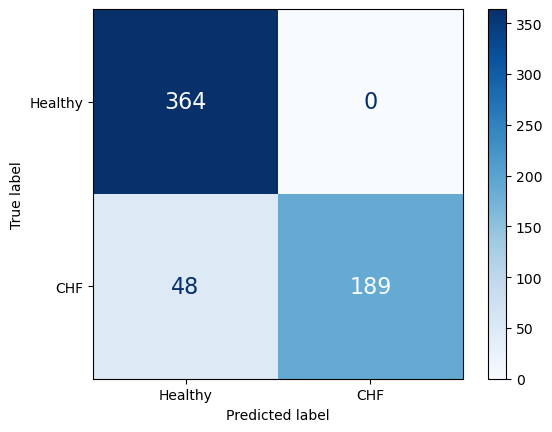

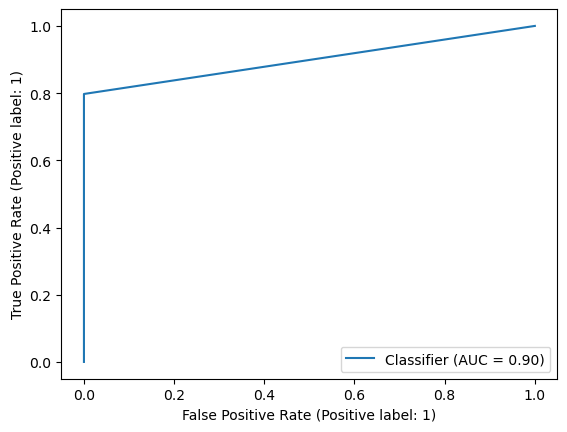

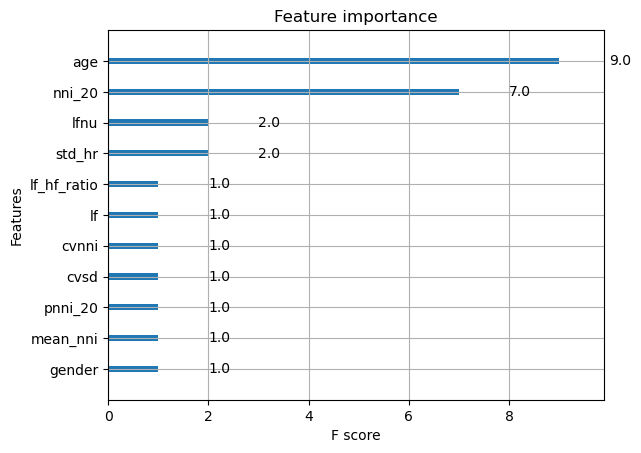

In [30]:
y_pred_train = gs_sensitivity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_sensitivity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity.best_estimator_)
plt.show()

In [31]:
print("Best Params")
pprint.pprint(gs_sensitivity.best_params_)
print()

Best Params
{'colsample_bytree': 0.6,
 'gamma': 2,
 'learning_rate': 0.3,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 50,
 'subsample': 0.6}



### Specificity

In [32]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

specificity = make_scorer(recall_score, pos_label=0)

gs_specificity = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring=specificity,
)

In [33]:
start = datetime.datetime.now()
gs_specificity.fit(X_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 31)
Fitting time: 0 hours, 1 minutes, 47 seconds, 769805 microseconds


In [34]:
gs_specificity.score(X_test, y_test)

1.0

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




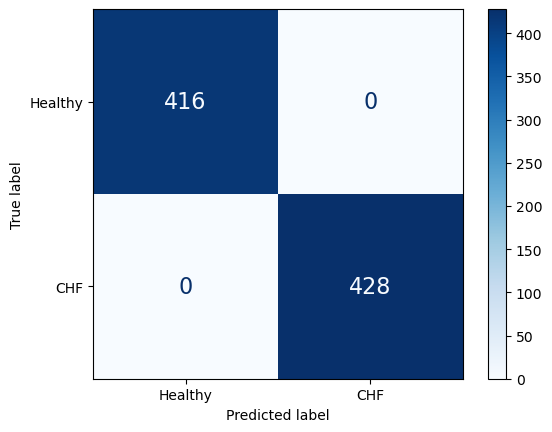


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 48 189
Accuracy             : 0.9201331114808652
Precision            : 0.9294379916966867
Sensitivity          : 0.7974683544303798
Specificity          : 1.0
F1-Score             : 0.9181036784199027
AUC Score            : 0.8987341772151899
              precision    recall  f1-score   support

     Healthy       0.88      1.00      0.94       364
         CHF       1.00      0.80      0.89       237

    accuracy                           0.92       601
   macro avg       0.94      0.90      0.91       601
weighted avg       0.93      0.92      0.92       601




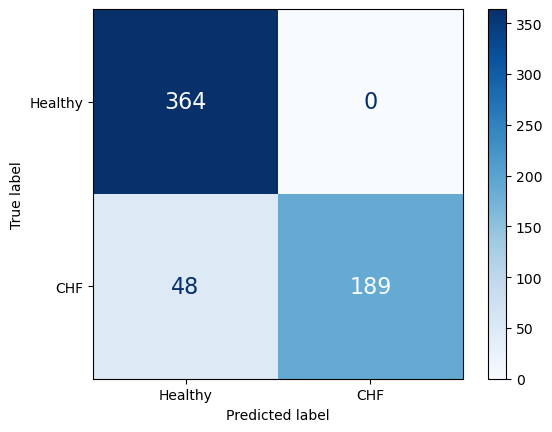

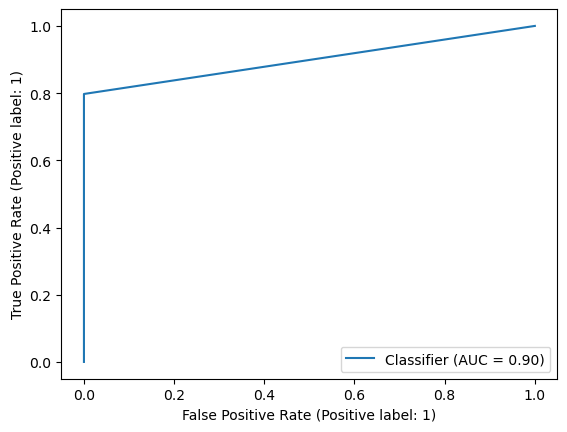

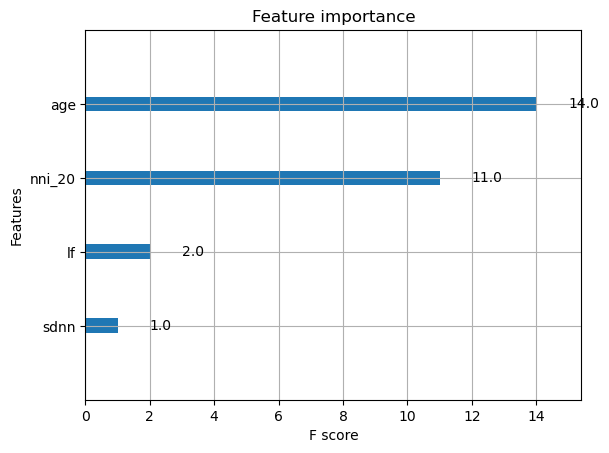

In [35]:
y_pred_train = gs_specificity.best_estimator_.predict(X_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()
print()

y_pred = gs_specificity.best_estimator_.predict(X_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_specificity.best_estimator_)
plt.show()

In [36]:
print("Best Params")
pprint.pprint(gs_specificity.best_params_)
print()

Best Params
{'colsample_bytree': 1.0,
 'gamma': 1,
 'learning_rate': 0.4,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 50,
 'subsample': 1.0}



## Save model

In [37]:
import pickle
# Ref: https://stackoverflow.com/questions/57730192/how-to-save-gridsearchcv-xgboost-model

# Dictionary of best parameters
best_pars = gs.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = gs.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))

In [38]:
# Ref: https://stackoverflow.com/a/64823806

import joblib

#save your model or results
gs_filename = f"xgb-gs-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs, os.path.join(MODEL_DIR, gs_filename))

#load your model for further usage
gs_best = joblib.load(os.path.join(MODEL_DIR, gs_filename))


In [39]:
gs_best.best_estimator_.score(X_test, y_test), gs_best.best_params_

(0.9201331114808652,
 {'colsample_bytree': 1.0,
  'gamma': 1,
  'learning_rate': 0.4,
  'max_depth': 4,
  'min_child_weight': 1,
  'n_estimators': 50,
  'subsample': 1.0})

### Sensitivity

In [40]:
import pickle

# Best XGB model that was found based on the metric score you specify
best_model = gs_sensitivity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-sensitivity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_sensitivity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_sensitivity_filename = f"xgb-gs_sensitivity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_sensitivity, os.path.join(MODEL_DIR, gs_sensitivity_filename))

#load your model for further usage
gs_sensitivity_best = joblib.load(os.path.join(MODEL_DIR, gs_sensitivity_filename))
print(gs_sensitivity_best.best_params_)

{'colsample_bytree': 0.6, 'gamma': 2, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.6}


### Specificity

In [41]:
import pickle
import joblib

# Best XGB model that was found based on the metric score you specify
best_model = gs_specificity.best_estimator_
# Save model
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
now = datetime.datetime.now()
strftime = now.strftime("%Y-%m-%d-%H-%M-%S")
model_filename = f"xgb-specificity_5-min-HRV-best-{strftime}.pickle"
pickle.dump(gs_specificity.best_estimator_, open(os.path.join(MODEL_DIR, model_filename), "wb"))


gs_specificity_filename = f"xgb-gs_specificity-object_5-min-HRV-best-{strftime}.pkl"
joblib.dump(gs_specificity, os.path.join(MODEL_DIR, gs_specificity_filename))

#load your model for further usage
gs_specificity_best = joblib.load(os.path.join(MODEL_DIR, gs_specificity_filename))
print(gs_specificity_best.best_params_)

{'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.4, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}


## Feature Selection

In [42]:
# ref: https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
importance_score = gs.best_estimator_.get_booster().get_score(importance_type='weight')
top_importance_score = {k: v for k, v in sorted(importance_score.items(), key=lambda item: item[1], reverse=True)}

top_5_features = []
top_10_features = []
top_15_features = []
for k, v in top_importance_score.items():
    if len(top_5_features) < 5:
        top_5_features.append(k)
    if len(top_10_features) < 10:
        top_10_features.append(k)
    if len(top_15_features) < 15:
        top_15_features.append(k)

### ReFit - Top 5

In [43]:
X_top_5_train = X_train[top_5_features]
X_top_5_test = X_test[top_5_features]

print(X_top_5_train.shape, y_train.shape)
print(X_top_5_test.shape, y_test.shape)

(844, 4) (844,)
(601, 4) (601,)


In [44]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_5 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [45]:
start = datetime.datetime.now()
gs_sensitivity_top_5.fit(X_top_5_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_5_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 4)
Fitting time: 0 hours, 0 minutes, 54 seconds, 577980 microseconds


In [46]:
gs_sensitivity_top_5.score(X_top_5_test, y_test)

0.8776371308016878

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




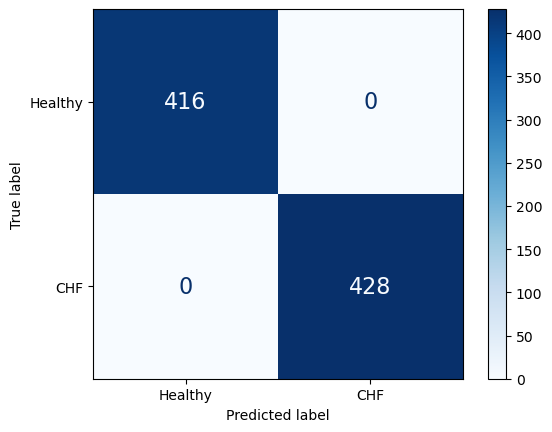


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 29 208
Accuracy             : 0.9517470881863561
Precision            : 0.9553077356229862
Sensitivity          : 0.8776371308016878
Specificity          : 1.0
F1-Score             : 0.9510990654679229
AUC Score            : 0.9388185654008439
              precision    recall  f1-score   support

     Healthy       0.93      1.00      0.96       364
         CHF       1.00      0.88      0.93       237

    accuracy                           0.95       601
   macro avg       0.96      0.94      0.95       601
weighted avg       0.96      0.95      0.95       601




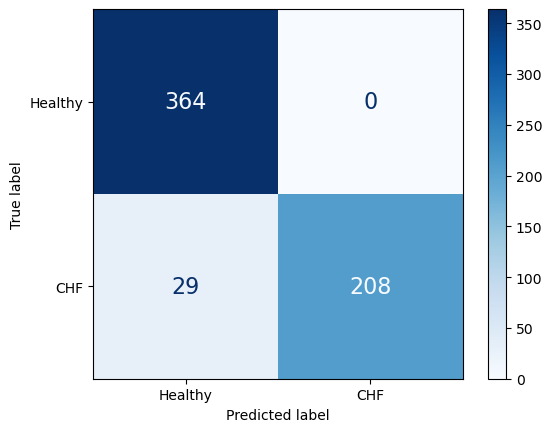

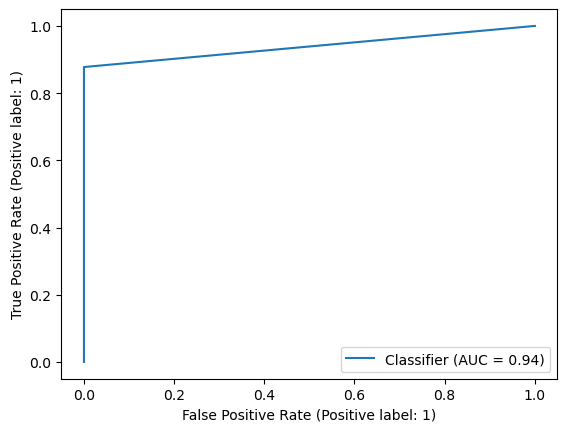

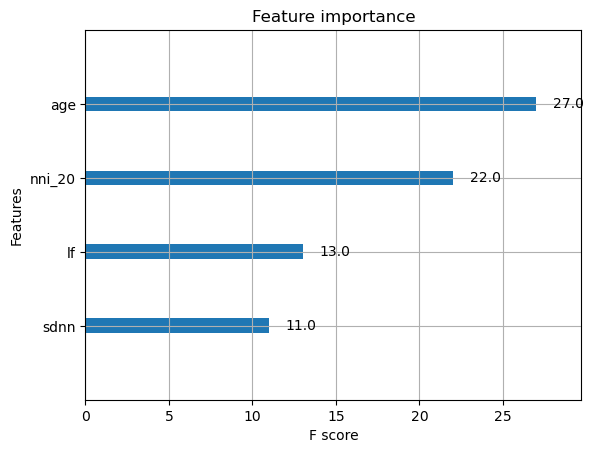

In [47]:
y_pred_train = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_5.best_estimator_.predict(X_top_5_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_5.best_estimator_)
plt.show()

### ReFit - Top 10

In [48]:
X_top_10_train = X_train[top_10_features]
X_top_10_test = X_test[top_10_features]

print(X_top_10_train.shape, y_train.shape)
print(X_top_10_test.shape, y_test.shape)

(844, 4) (844,)
(601, 4) (601,)


In [49]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_10 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [50]:
start = datetime.datetime.now()
gs_sensitivity_top_10.fit(X_top_10_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_10_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 4)
Fitting time: 0 hours, 0 minutes, 51 seconds, 80804 microseconds


In [51]:
gs_sensitivity_top_10.score(X_top_10_test, y_test)

0.9201331114808652

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




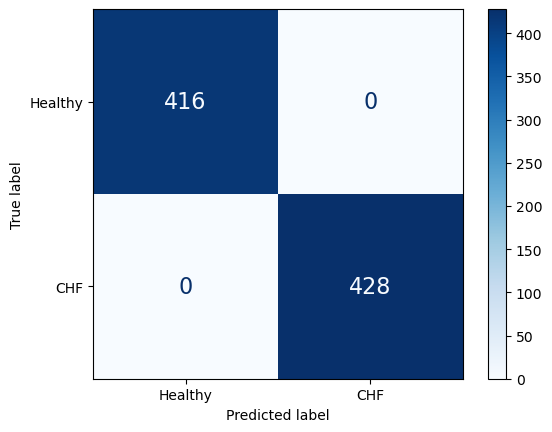


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 48 189
Accuracy             : 0.9201331114808652
Precision            : 0.9294379916966867
Sensitivity          : 0.7974683544303798
Specificity          : 1.0
F1-Score             : 0.9181036784199027
AUC Score            : 0.8987341772151899
              precision    recall  f1-score   support

     Healthy       0.88      1.00      0.94       364
         CHF       1.00      0.80      0.89       237

    accuracy                           0.92       601
   macro avg       0.94      0.90      0.91       601
weighted avg       0.93      0.92      0.92       601




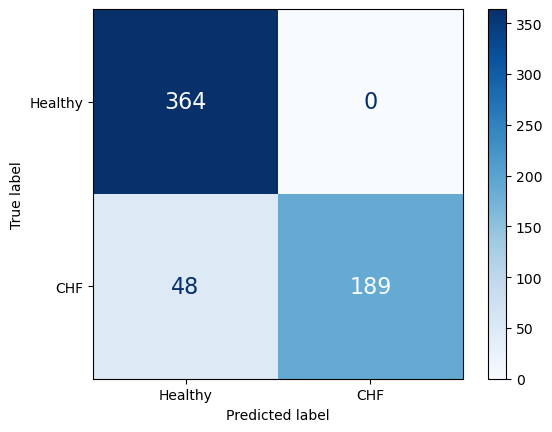

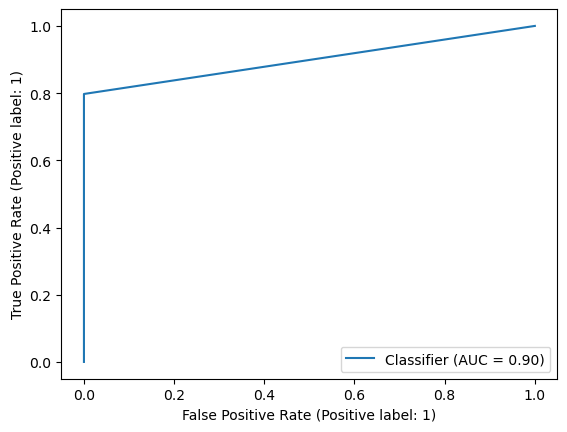

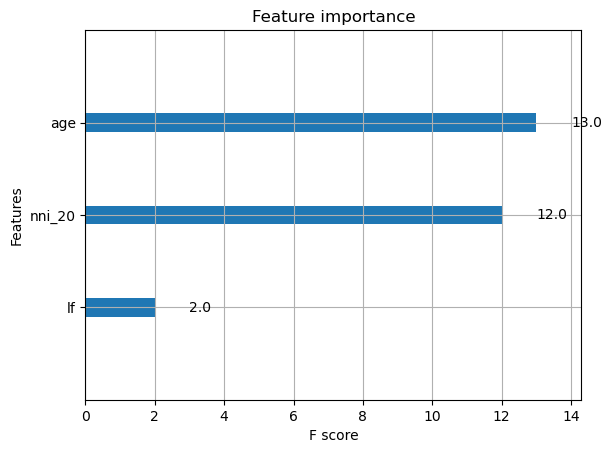

In [52]:
y_pred_train = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_10.best_estimator_.predict(X_top_10_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_10.best_estimator_)
plt.show()

### ReFit - Top 15

In [53]:
X_top_15_train = X_train[top_15_features]
X_top_15_test = X_test[top_15_features]

print(X_top_15_train.shape, y_train.shape)
print(X_top_15_test.shape, y_test.shape)

(844, 4) (844,)
(601, 4) (601,)


In [54]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_top_15 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="accuracy"
)

In [55]:
start = datetime.datetime.now()
gs_sensitivity_top_15.fit(X_top_15_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_top_15_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 4)
Fitting time: 0 hours, 0 minutes, 51 seconds, 73768 microseconds


In [56]:
gs_sensitivity_top_15.score(X_top_15_test, y_test)

0.9201331114808652

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




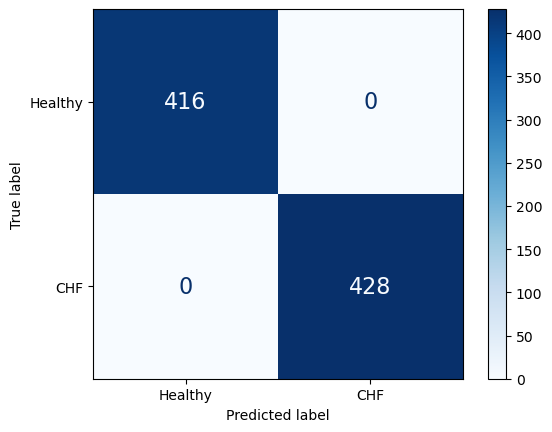


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 48 189
Accuracy             : 0.9201331114808652
Precision            : 0.9294379916966867
Sensitivity          : 0.7974683544303798
Specificity          : 1.0
F1-Score             : 0.9181036784199027
AUC Score            : 0.8987341772151899
              precision    recall  f1-score   support

     Healthy       0.88      1.00      0.94       364
         CHF       1.00      0.80      0.89       237

    accuracy                           0.92       601
   macro avg       0.94      0.90      0.91       601
weighted avg       0.93      0.92      0.92       601




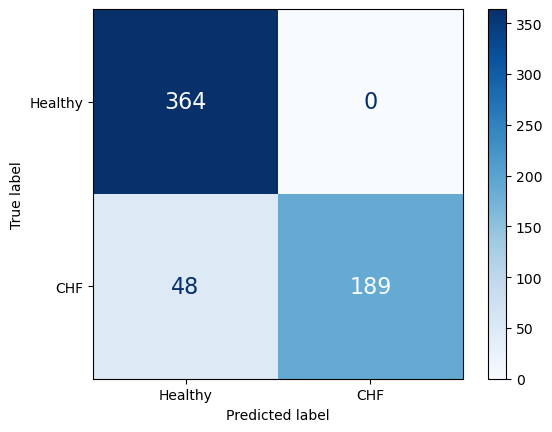

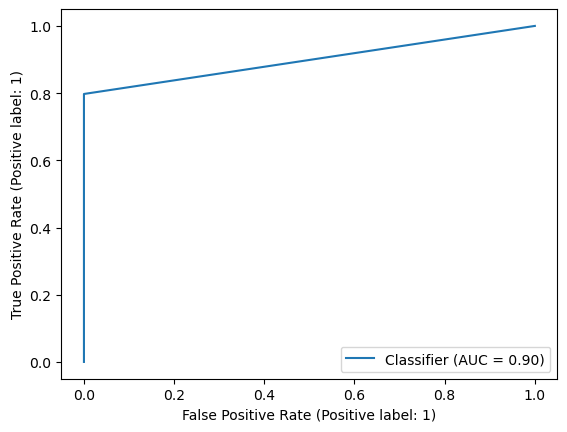

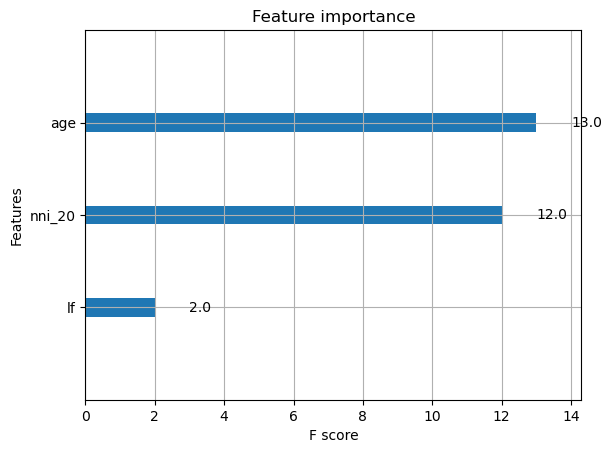

In [57]:
y_pred_train = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_top_15.best_estimator_.predict(X_top_15_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_top_15.best_estimator_)
plt.show()

## Feature Reduction

### Remove Age

In [58]:
columns_wo_age = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_age.remove("age")

In [59]:
X_wo_age_train = X_train[columns_wo_age]
X_wo_age_test = X_test[columns_wo_age]

print(X_wo_age_train.shape, y_train.shape)
print(X_wo_age_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_age_train.sample(3))
pd.reset_option("display.max_columns")

(844, 30) (844,)
(601, 30) (601,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
1049,1,611.053061,8.082476,6.385033,0,0.000000,0,0.000000,6.385054,612.0,44.0,0.010449,0.013227,98.208244,101.351351,94.339623,1.294228,3.081611,3.711460,0.830296,45.364035,54.635965,41.448519,34.655448,4.519524,10.498893,0.430476,2.323009,2.880356,97.556073
1322,1,504.235690,6.243918,7.935614,2,0.337268,3,0.505902,7.935660,504.0,108.0,0.015738,0.012383,119.010853,138.888889,111.111111,1.529672,5.341822,5.695711,0.937867,48.396883,51.603117,17.279570,6.242038,5.616064,6.814166,0.824175,1.213335,2.786965,33.071456
1226,1,879.905882,17.778462,13.883624,0,0.000000,33,9.734513,13.883629,880.0,108.0,0.015779,0.020205,68.216914,72.815534,64.377682,1.378724,85.576540,47.517659,1.800942,64.297723,35.702277,243.347954,110.253755,9.831717,23.140544,0.424870,2.353663,3.561123,217.860132


In [60]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_age = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)


In [61]:
start = datetime.datetime.now()
gs_sensitivity_wo_age.fit(X_wo_age_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_age_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 30)
Fitting time: 0 hours, 2 minutes, 6 seconds, 227216 microseconds


In [62]:
gs_sensitivity_wo_age.score(X_wo_age_test, y_test)

0.9535864978902954

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




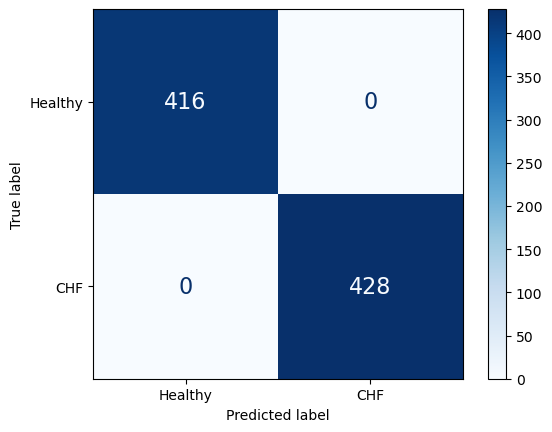


TEST SET RESULTS
TN, FP, FN, TP       : 361 3 11 226
Accuracy             : 0.9767054908485857
Precision            : 0.976924718213536
Sensitivity          : 0.9535864978902954
Specificity          : 0.9917582417582418
F1-Score             : 0.9766321385735474
AUC Score            : 0.9726723698242685
              precision    recall  f1-score   support

     Healthy       0.97      0.99      0.98       364
         CHF       0.99      0.95      0.97       237

    accuracy                           0.98       601
   macro avg       0.98      0.97      0.98       601
weighted avg       0.98      0.98      0.98       601




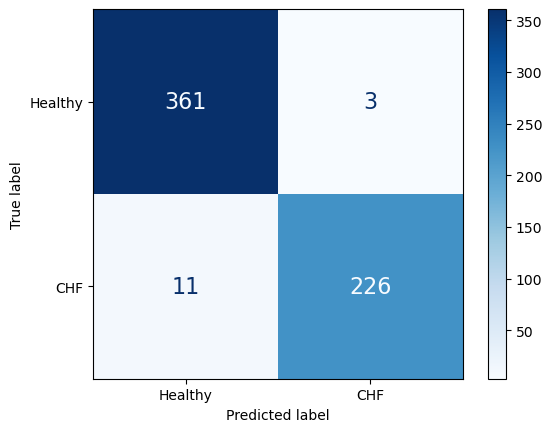

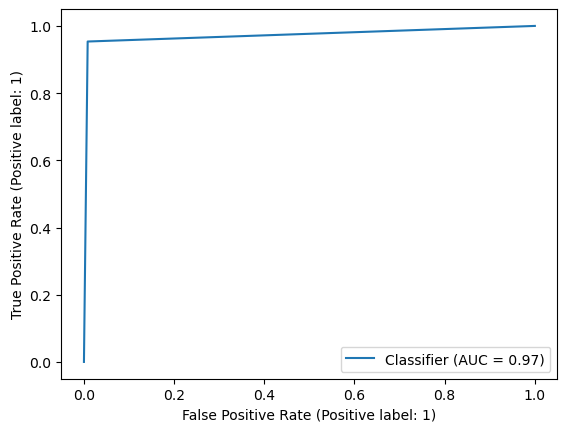

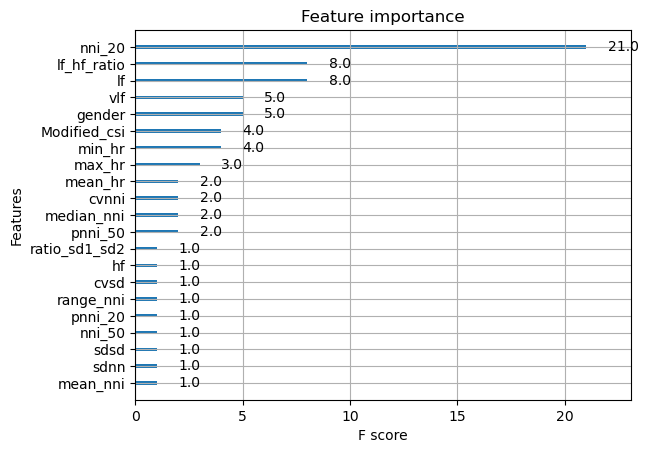

In [63]:
y_pred_train = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_age.best_estimator_.predict(X_wo_age_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_age.best_estimator_)
plt.show()

### Remove LF/HF

In [64]:
columns_wo_lf_hf_ratio = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_lf_hf_ratio.remove("lf_hf_ratio")

In [65]:
X_wo_lf_hf_ratio_train = X_train[columns_wo_lf_hf_ratio]
X_wo_lf_hf_ratio_test = X_test[columns_wo_lf_hf_ratio]

print(X_wo_lf_hf_ratio_train.shape, y_train.shape)
print(X_wo_lf_hf_ratio_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_lf_hf_ratio_train.sample(3))
pd.reset_option("display.max_columns")

(844, 30) (844,)
(601, 30) (601,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
436,45.0,0,743.854684,115.469664,28.465348,38,9.452736,153,38.059701,28.473944,726.5625,484.37500,0.038279,0.155231,82.559137,102.400000,56.058394,12.343464,666.534584,189.514369,77.861737,22.138263,1459.227510,603.178557,20.153122,162.050419,0.124363,8.040959,4.718112,5212.162799
395,20.0,0,811.053632,281.982868,138.221173,132,35.772358,207,56.097561,138.227207,875.0000,933.59375,0.170429,0.347675,87.215125,199.480519,48.607595,41.067376,4235.078894,5053.539024,45.594285,54.405715,14573.997448,5285.379531,97.869834,386.587857,0.253163,3.950021,5.782017,6108.119939
868,71.0,1,983.381579,21.267721,16.854958,0,0.000000,55,18.151815,16.855041,984.0000,128.00000,0.017140,0.021627,61.042722,65.502183,57.471264,1.332902,25.122541,44.469915,36.099518,63.900482,308.753581,239.161126,11.937971,27.606462,0.432434,2.312492,3.722061,255.358889


In [66]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_lf_hf_ratio = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [67]:
start = datetime.datetime.now()
gs_sensitivity_wo_lf_hf_ratio.fit(X_wo_lf_hf_ratio_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_lf_hf_ratio_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 30)
Fitting time: 0 hours, 1 minutes, 46 seconds, 331227 microseconds


In [68]:
gs_sensitivity_wo_lf_hf_ratio.score(X_wo_lf_hf_ratio_test, y_test)

0.8987341772151899

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




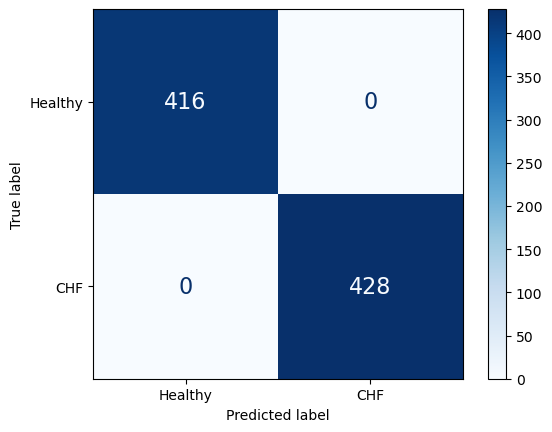


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 24 213
Accuracy             : 0.9600665557404326
Precision            : 0.9625366656946327
Sensitivity          : 0.8987341772151899
Specificity          : 1.0
F1-Score             : 0.9596388997061637
AUC Score            : 0.9493670886075949
              precision    recall  f1-score   support

     Healthy       0.94      1.00      0.97       364
         CHF       1.00      0.90      0.95       237

    accuracy                           0.96       601
   macro avg       0.97      0.95      0.96       601
weighted avg       0.96      0.96      0.96       601




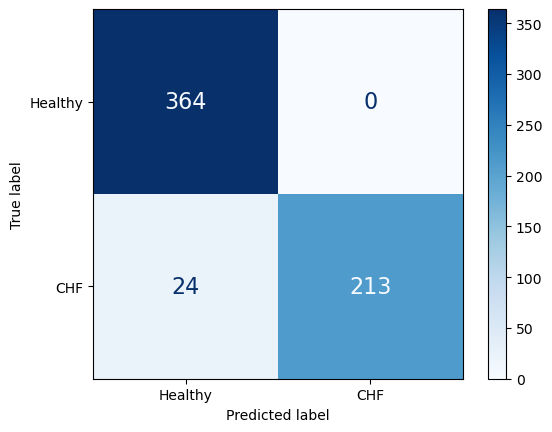

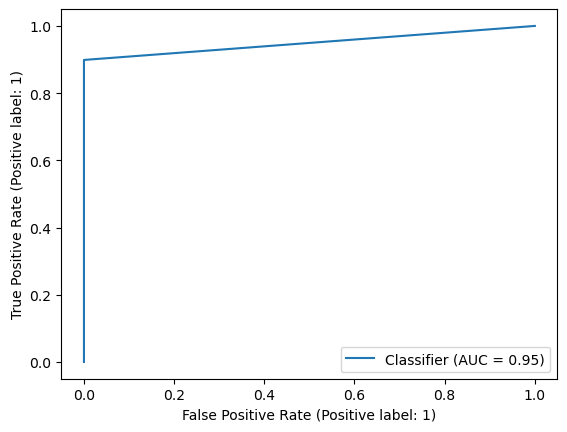

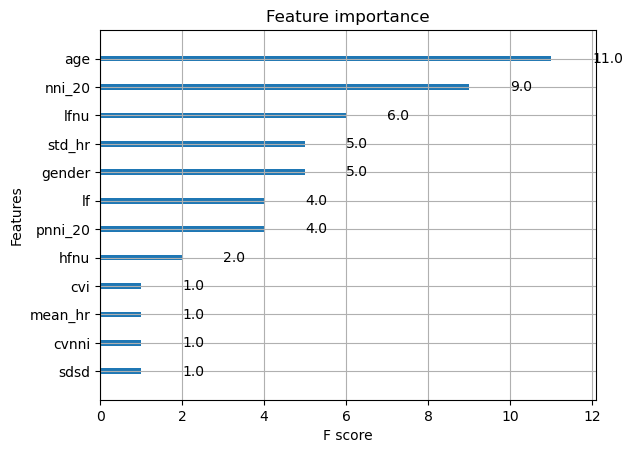

In [69]:
y_pred_train = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_lf_hf_ratio.best_estimator_.predict(X_wo_lf_hf_ratio_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_lf_hf_ratio.best_estimator_)
plt.show()

### Remove NNI_20

In [70]:
columns_wo_nni_20 = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_nni_20.remove("nni_20")

In [71]:
X_wo_nni_20_train = X_train[columns_wo_nni_20]
X_wo_nni_20_test = X_test[columns_wo_nni_20]

print(X_wo_nni_20_train.shape, y_train.shape)
print(X_wo_nni_20_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_nni_20_train.sample(3))
pd.reset_option("display.max_columns")

(844, 30) (844,)
(601, 30) (601,)


,age,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
1287,63.0,0,581.680934,6.748572,9.951148,3,0.584795,0.779727,9.951148,580.0000,140.00000,0.017108,0.011602,103.163653,120.00000,93.750000,1.240007,3.333886,8.539349,0.390415,28.079006,71.920994,14.424198,2.550962,7.043392,6.440269,1.093649,0.914370,2.860806,23.555167
211,42.0,1,605.421497,48.407033,30.618304,27,5.454545,41.818182,30.618890,601.5625,496.09375,0.050575,0.079956,99.795101,194.43038,74.563107,9.148827,804.935354,55.706314,14.449625,93.527351,6.472649,1357.102225,496.460557,21.672313,64.936835,0.333745,2.996304,4.352516,778.281956
1274,63.0,0,581.413592,11.609980,17.527700,3,0.583658,6.809339,17.527743,580.0000,248.00000,0.030147,0.019969,103.236956,125.00000,82.417582,2.035543,16.053292,31.256088,0.513605,33.932577,66.067423,50.795619,3.486238,12.406030,10.755172,1.153494,0.866931,3.329370,37.295966


In [72]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_nni_20 = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [73]:
start = datetime.datetime.now()
gs_sensitivity_wo_nni_20.fit(X_wo_nni_20_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_nni_20_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 30)
Fitting time: 0 hours, 1 minutes, 47 seconds, 122142 microseconds


In [74]:
gs_sensitivity_wo_nni_20.score(X_wo_nni_20_test, y_test)

0.9029535864978903

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




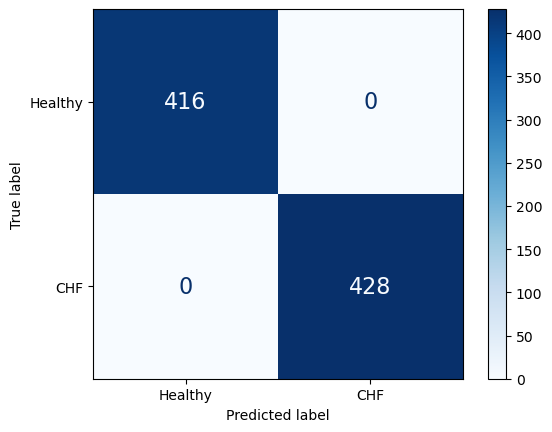


TEST SET RESULTS
TN, FP, FN, TP       : 364 0 23 214
Accuracy             : 0.961730449251248
Precision            : 0.9640048669960056
Sensitivity          : 0.9029535864978903
Specificity          : 1.0
F1-Score             : 0.9613406365548485
AUC Score            : 0.9514767932489452
              precision    recall  f1-score   support

     Healthy       0.94      1.00      0.97       364
         CHF       1.00      0.90      0.95       237

    accuracy                           0.96       601
   macro avg       0.97      0.95      0.96       601
weighted avg       0.96      0.96      0.96       601




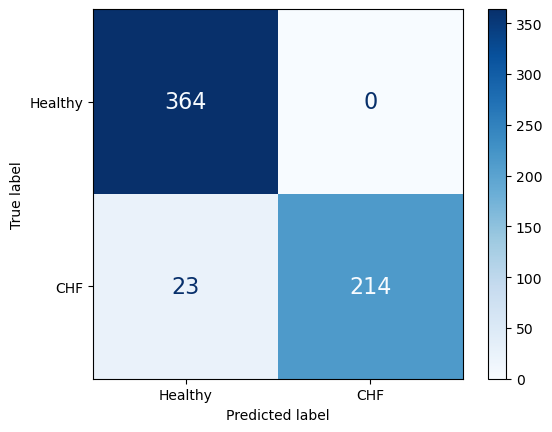

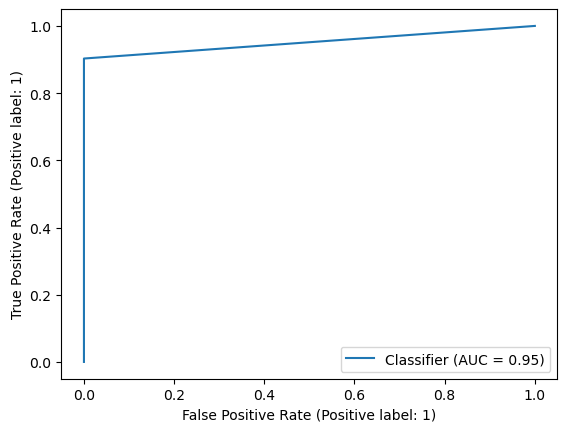

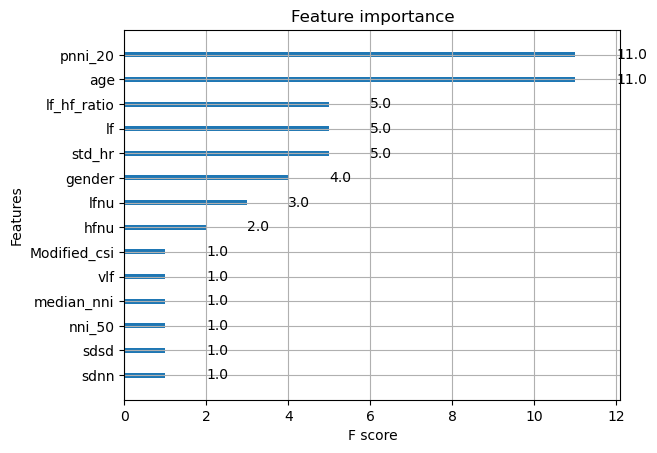

In [75]:
y_pred_train = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_nni_20.best_estimator_.predict(X_wo_nni_20_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_nni_20.best_estimator_)
plt.show()

### Remove Age, LF/HF, NNI_20

In [76]:
columns_wo_all = ['age'] + \
                 ['gender'] + \
                 time_domain_indices + freq_domain_indices + \
                 poincare_plot_indices + \
                 csi_csv_indices

columns_wo_all.remove("age")
columns_wo_all.remove("lf_hf_ratio")
columns_wo_all.remove("nni_20")

In [77]:
X_wo_all_train = X_train[columns_wo_all]
X_wo_all_test = X_test[columns_wo_all]

print(X_wo_all_train.shape, y_train.shape)
print(X_wo_all_test.shape, y_test.shape)

pd.set_option('display.max_columns', None)
display(X_wo_all_train.sample(3))
pd.reset_option("display.max_columns")

(844, 28) (844,)
(601, 28) (601,)


,gender,mean_nni,sdnn,sdsd,nni_50,pnni_50,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lfnu,hfnu,total_power,vlf,sd1,sd2,ratio_sd1_sd2,csi,cvi,Modified_csi
234,1,634.186308,31.021935,23.464982,23,4.883227,30.360934,23.465129,632.8125,218.750,0.037000,0.048916,94.827496,106.666667,76.800000,4.476619,661.747477,42.428581,93.974720,6.025280,849.894515,145.718457,16.609890,40.605818,0.409052,2.444677,4.033075,397.072453
436,0,743.854684,115.469664,28.465348,38,9.452736,38.059701,28.473944,726.5625,484.375,0.038279,0.155231,82.559137,102.400000,56.058394,12.343464,666.534584,189.514369,77.861737,22.138263,1459.227510,603.178557,20.153122,162.050419,0.124363,8.040959,4.718112,5212.162799
994,1,921.907121,25.188557,31.207580,10,3.105590,5.590062,31.207580,920.0000,280.000,0.033851,0.027322,65.128539,72.815534,54.347826,1.698418,48.018314,248.891463,16.172696,83.827304,363.616366,66.706589,22.101437,27.936594,0.791129,1.264017,3.994714,141.249326


In [78]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=12,
)

gs_sensitivity_wo_all = GridSearchCV(
    xgb,
    param_grid=params,
    n_jobs=30,
    verbose=3,
    return_train_score=True,
    cv=StratifiedKFold(n_splits=10),
    scoring="recall"
)

In [79]:
start = datetime.datetime.now()
gs_sensitivity_wo_all.fit(X_wo_all_train, y_train)
fit_time = datetime.datetime.now() - start
print("Train data shape:", X_wo_all_train.shape)

text = "Fitting time: {} hours, {} minutes, {} seconds, {} microseconds".format(
    fit_time.seconds // 3600,
    fit_time.seconds % 3600 // 60,
    fit_time.seconds % 60,
    fit_time.microseconds
)

print(text)

Fitting 10 folds for each of 4536 candidates, totalling 45360 fits
Train data shape: (844, 28)
Fitting time: 0 hours, 2 minutes, 4 seconds, 375409 microseconds


In [80]:
gs_sensitivity_wo_all.score(X_wo_all_test, y_test)

0.9789029535864979

TRAIN SET RESULTS
TN, FP, FN, TP       : 416 0 0 428
Accuracy (Train)     : 1.0
Precision (Train)    : 1.0
Sensitivity (Train)  : 1.0
Specificity (Train)  : 1.0
F1-Score (Train)     : 1.0
AUC Score (Train)    : 1.0
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       416
         CHF       1.00      1.00      1.00       428

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844




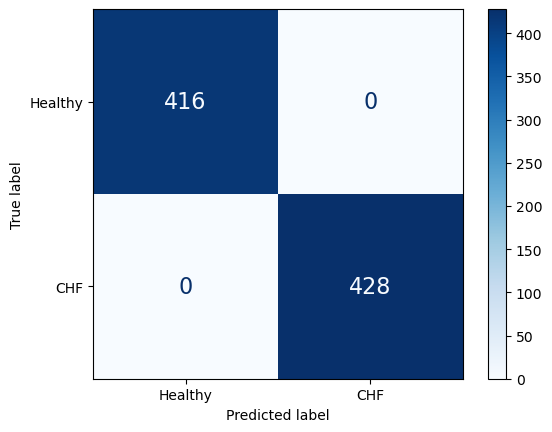


TEST SET RESULTS
TN, FP, FN, TP       : 361 3 5 232
Accuracy             : 0.9866888519134775
Precision            : 0.9866918310973012
Sensitivity          : 0.9789029535864979
Specificity          : 0.9917582417582418
F1-Score             : 0.986678884777982
AUC Score            : 0.9853305976723699
              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       364
         CHF       0.99      0.98      0.98       237

    accuracy                           0.99       601
   macro avg       0.99      0.99      0.99       601
weighted avg       0.99      0.99      0.99       601




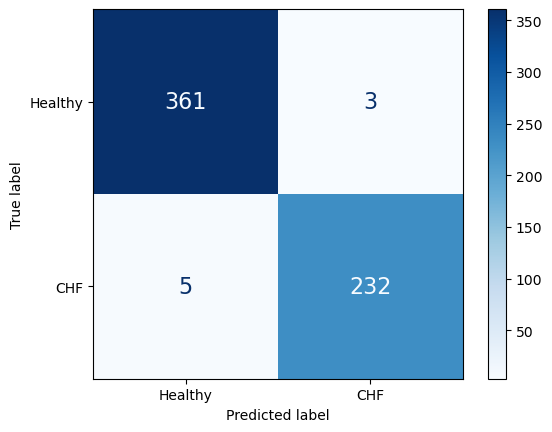

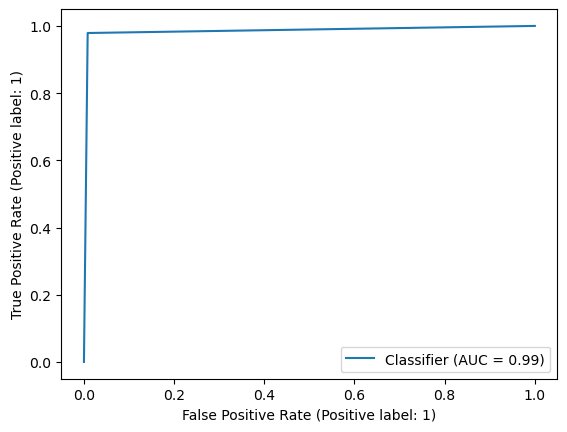

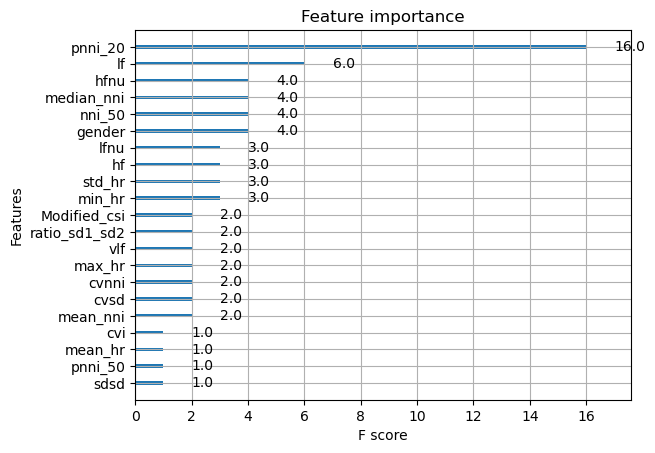

In [81]:
y_pred_train = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_train)
AVERAGE = 'weighted'
tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average=AVERAGE)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train, average=AVERAGE)
sensitivity_train = recall_score(y_true=y_train, y_pred=y_pred_train)
specificity_train = recall_score(y_true=y_train, y_pred=y_pred_train, pos_label=0)
auc_train = roc_auc_score(y_train, y_pred_train, average=AVERAGE)
print("TRAIN SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy (Train)     :", accuracy_train)
print("Precision (Train)    :", precision_train)
print("Sensitivity (Train)  :", sensitivity_train)
print("Specificity (Train)  :", specificity_train)
print("F1-Score (Train)     :", f1_train)
print("AUC Score (Train)    :", auc_train)
print(classification_report(y_train, y_pred_train, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_train, y_pred_train,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16
    }
)
plt.show()
print()

y_pred = gs_sensitivity_wo_all.best_estimator_.predict(X_wo_all_test)
AVERAGE = 'weighted'
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
f1 = f1_score(y_true=y_test, y_pred=y_pred, average=AVERAGE)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = (tp + tn) / (tp + fp + tn + fn)
num_positives = len(np.where(y_test == 1)[0])
num_negatives = len(np.where(y_test == 0)[0])
precision = (num_positives*(tp / (tp + fp)) + num_negatives*(tn / (tn + fn))) / (num_positives + num_negatives)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

_precision = precision_score(y_test, y_pred, average=AVERAGE)
_sensitivity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=1, average='binary')
_specificity = recall_score(y_true=y_test, y_pred=y_pred, pos_label=0, average='binary')
assert precision == _precision
assert specificity == _specificity
assert sensitivity == _sensitivity

auc = roc_auc_score(y_test, y_pred, average=AVERAGE)
print("TEST SET RESULTS")
print("TN, FP, FN, TP       :", tn, fp, fn, tp)
print("Accuracy             :", accuracy)
print("Precision            :", precision)
print("Sensitivity          :", sensitivity)
print("Specificity          :", specificity)
print("F1-Score             :", f1)
print("AUC Score            :", auc)
print(classification_report(y_test, y_pred, target_names=LABEL_NAMES))
print()
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=LABEL_NAMES,
    cmap=plt.cm.Blues,
    text_kw={
        "fontsize": 16,
    },
)
plt.show()

print()
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
xgboost.plot_importance(gs_sensitivity_wo_all.best_estimator_)
plt.show()